* Topic:        Challenge Set 3
* Subject:      Pandas (Exploring and visualizing our scraped movie data in pandas)
* Date:         TODO
* Name:         Michael Green ( malexgreen@gmail.com )

What data do I need to read in if I'm going to scrape IMDB.com?

Here's what is in `GITROOT/challenges/challenges_data/2013_movies.csv`

```csv
Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate

```

So if I'm going to scrape IMDB, I'll need the same data:

* `title`: Name of the movie
* `budget`: How much money was spent to make the movie
* `domesticTotalGross`: How much money did the movie make in gross ticket sales in the US
* `rating`: MPAA Rating
* `director`: Name of the director
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT

Note: This code will be reused for [Project 2](https://github.com/michael-a-green/onl20_ds4/blob/master/curriculum/project-02/project-02-introduction/project_02.md). Some of the fetures extracted in this notebook are used for this challenge (Challenge Set 3) and other features are used in the project.

Below are the features that are extracted in this notebook that are used for the challenge:

* `title`: Name of the movie
* `budget`: How much money was spent to make the movie
* `domesticTotalGross`: How much money did the movie make in gross ticket sales in the US
* `rating`: MPAA Rating
* `director`: Name of the director
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT

Below are the features that will be used in the linear regression that will be performed in Project 2:

* `budget`: How much money was spent to make the movie
* `rating`: MPAA Rating, one-hot encoded
* `encodedDirector`: Name of the director, but encoded in a specific way that will be explained below
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT
* `genre` one-hot encoded. See below for more details
* `runtime` measured in minutes
* `encodedCast1` one-hot encoded value of the name of a cast member if that cast member is in a specific list of cast members. Details of the encoding are explained below
* `encodedCast2` one-hot encoded value of the name of a another cast member if that cast member is in a specific list of cast members. Details of the encoding are explained below




Notes on imdb.com web page structure:

I searched for the move _Star Wars: Episode IV - A New Hope_.

This is the URL it gave to me:
`https://www.imdb.com/title/tt0076759/?ref_=nv_sr_srsg_0`

This is where I found the content I need for this page`<div>` of a movie entry:

```html
<div id="pagecontent" class="pagecontent">
    <div id="main_bottom" class="main">
        
        <div class="article" id="titleStoryLine">
            
        </div>
    
    
    <div class="article" id="titleDetails">

        <div class="txt-block>
            <h4 class="inline">Release Date:</h4>
            " 25 May 1977 (USA) "
            <!-- more stuff see web page for details -->
        </div>
        <div class="txt-block>
            <h4 class="inline">Also Known As:</h4>
            " Star Wars: Episode IV - A New Hope "
             <!-- more stuff see web page for details -->
        </div>
        <h3 class="subheading">Box Office</h3>
        <div class="txt-block">
            <h4 class="inline">Budget:</h4>
            "$11,000,000 "
            <!-- more stuff see web page for details -->
        </div>
        <div class="txt-block">
            <h4 class="inline">Gross USA:</h4>
            " $460,998,507 "
        </div>
        
    </div>

</div>


```

In [658]:
#Just going to try beautiful soup to see if I can grab all of the txt-blocks
from bs4 import BeautifulSoup
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import pickle
import os
import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [659]:
#movie module
from mymovie import Movie

In [660]:
%matplotlib inline

In [661]:
def my_wait(start,stop):
    """
    waits a number of seconds randomly selected between start and stop
    """
    if start <= 0:
        start = 10
    
    if stop <= 0:
        stop = 30
    
    if stop <= start:
        stop = start + 10
    
    wait_time = randint(start,stop)
    
    time.sleep(wait_time)
    
    return
    

In [662]:
def my_print(print_string,debug=0,LOG_FILE=None):
    """
    LOG_FILE = Must be a file handle
    """
    
    if (debug):
        if (LOG_FILE == None):
            print(print_string)
        else:
            print(print_string, file=LOG_FILE)


In [663]:
star_wars = Movie("Star Wars Episode IV","www.intel.com")
my_print(star_wars,1)

title = Star Wars Episode IV domesticTotalGross = 0 rating =  director =  releaseDate =  runtime = 0 cast1 =  cast2 =  cast3 =   genre =  budget = 0 star_rating = 0 directlink_url = www.intel.com


In [664]:
#search for movies released in 2013

#Set DEBUG to some_value >= 1 if you want to see debug messages
DEBUG = 1
log_file_name = "notebook.log"
LOG_FILE = open(log_file_name,"w")

RANDOM_STATE = 42

RUN_SCRAPE = 0

#possibly better search
#search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&certificates=US%3AG,US%3APG,US%3APG-13,US%3AR,US%3ANC-17"
#search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2013-01-01,2013-12-31"

search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&certificates=US%3AG,US%3APG,US%3APG-13,US%3AR,US%3ANC-17&countries=us"

IMDB_ROOT_URL = "http://www.imdb.com"

list_of_movie_objects = []

#flag that tells me if this is the first search I 
#sent to IMDB or not (1 means it's the first search, 0 means it's a subsequent search)
first_search = 1

NUMBER_OF_MOVIES = 4000
NUMBER_OF_MOVIES_PER_SEARCH = 50

#won't exactly get the number of movies I want but won't get
#less than the number of movies I want
if (NUMBER_OF_MOVIES % NUMBER_OF_MOVIES_PER_SEARCH) == 0:
    number_of_searches = NUMBER_OF_MOVIES // NUMBER_OF_MOVIES_PER_SEARCH
else:
    number_of_searches = (NUMBER_OF_MOVIES // NUMBER_OF_MOVIES_PER_SEARCH) + 1


#FOR DEBUG ONLY
#hard coding number_of_searches
#number_of_searches = 3


    

In [665]:
#search IMD for movies
#find direct link to movies
#create a movie object with the title and the link to the movie
#write it to a pickle file
#find link to next search
if RUN_SCRAPE:
    for i in range(number_of_searches):
    
        my_print("\nwaiting before I scrape...", DEBUG, LOG_FILE)
        my_wait(10,35)
        my_print("done waiting", DEBUG, LOG_FILE)
        
        if os.path.isfile("STOP_SEARCHING.txt"):
            print("Saw file STOP_SEARCHING.txt. So will stop searching for movies")
            break
    
        #DANGER: INITIATE SEARCH REQUEST TO IMDB
        web_response = requests.get(search_url)
    
        if (web_response.status_code == 200):
            my_print("web request was good", DEBUG, LOG_FILE)
        else:
            print("error: web request failed",DEBUG, LOG_FILE)
            break
    
        #contains IMDB movie search results
        web_response_text = web_response.text
        my_print("got web response text", DEBUG, LOG_FILE)
    
        #convert web response to a soup object
        web_response_soup = BeautifulSoup(web_response_text)
    
        my_print("got web response soup", DEBUG, LOG_FILE)
    
        #the <div> that has the data I want is this one
        listOfListerItemContentDIV = web_response_soup.find_all("div",class_="lister-item-content")
    
        my_print("got divs for movies", DEBUG, LOG_FILE)
    
        if first_search == 1:
            PICKLE_FILE = open("Movie_objects.pkl","wb")
            my_print("opening pickle file for writing", DEBUG, LOG_FILE)
        else:
            PICKLE_FILE = open("Movie_objects.pkl","ab")
            my_print("opening pickle file for appending", DEBUG, LOG_FILE)


    
        #########################################################
        #
        # search through the <div class_="lister-item-content> tags
        # looking for the information I want
        #
        ###########################################################
        for listerItemContentDIV in listOfListerItemContentDIV:
        
            #these accesses  rely on the knowledge of the structure
            #of the web page. hopefully it doesn't change a lot
            link_to_movie = listerItemContentDIV.h3.a.get("href")
            title_of_the_movie = listerItemContentDIV.h3.a.text
            link_to_movie = IMDB_ROOT_URL + link_to_movie
        
        
            #CREATING MOVIE OBJECT
            themovie = Movie(title_of_the_movie,link_to_movie)
        
            my_print(themovie, DEBUG, LOG_FILE)
        
            if themovie != None:
                #TODO: Check status of pickle.dump() call for error
                pickle.dump(themovie,PICKLE_FILE)
            else:
                my_print("error: themovie is None and should not be!", 1, LOG_FILE)
                break
        
            my_print("done writing pickl file", DEBUG, LOG_FILE)
        
        #we found the first 50 movie links
        #close the pickle
        PICKLE_FILE.close()
        #wait a little to give time to flush the file buffer
        my_wait(1,3)
    
        #grab link to the next 50 movies
        #The links are in the <div class="desc">
        listOfDescDIV = web_response_soup.find_all("div",class_="desc")
    
        #Big assumption. There will be two <div class="desc">
        #tags on the search web page, and that the "Next" link and the
        #"Previous" link will be in that <div> tag. So you can
        #always pick the first one
        DescDIV_a_tag = listOfDescDIV[0].find_all("a")
    
        for a_tag in DescDIV_a_tag:
            temp_text = a_tag.text
            if re.match(r"Next",temp_text):
                link_to_next_page = IMDB_ROOT_URL + a_tag.get("href")
    
        #going to try this
        #get text for DIV
        #pass it to soup to get another soup object
    
        my_print("link to next search page is {}".format(link_to_next_page), DEBUG, LOG_FILE)

    
        #doing this for debug purposes --> making debugging easier
    
        search_url = link_to_next_page
        first_search = 0
else:
    print("Skipping scrape")
    

Skipping scrape


In [666]:
if RUN_SCRAPE:
    #Check Code Uncomment to check pickle file
    #also reference for sear
    #Just going to grab all of the Movie objects out of the pickle file and see if they all got in
    PICKLE_FILE = open("Movie_objects.pkl","rb")

    #saving it here as a backup just in case I get locked out
    #at least I'll have the data
    EXPANDED_PICKLE_FILE = open("Movie_populated_objects.pkl","wb")
    list_of_populated_movies = []
    while 1:
                
        if os.path.isfile("STOP_EXPANDING.txt"):
            print("Saw file STOP_EXPANDIN.txt. So will stop populating movies.")
            break
            
        try:
            mymovie = pickle.load(PICKLE_FILE)
            mymovie.populate_movie(DEBUG=1,LOG_FILE=LOG_FILE,start_time=5,stop_time=17)
            #list_of_populated_movies.append(mymovie)
            pickle.dump(mymovie,EXPANDED_PICKLE_FILE)
            #uncomment for debugging only

            my_print(mymovie, DEBUG, LOG_FILE)
        
        except EOFError:
            break

    PICKLE_FILE.close()
    EXPANDED_PICKLE_FILE.close()
else:
    print("Skipping scrape")

Skipping scrape


Note if you are debugging and want to read in the full dataset, that file is called `Movie_populated_objects_4000.pkl`. You should copy that file to the name `Movie_populated_objects_4000.pkl` before running the next and subsequent shell. 

**TODO**: May add shell commmands to this automatically

How many movies did I scrape?

In [667]:
#Read In pickle file of populated objects
list_of_populated_movies = []
EXPANDED_PICKLE_FILE = open("Movie_populated_objects.pkl","rb")
while 1:
    
    try:
        mymovie = pickle.load(EXPANDED_PICKLE_FILE)
        list_of_populated_movies.append(mymovie)
        my_print(mymovie, DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE Reading in movie objects",DEBUG,LOG_FILE)
        break

EXPANDED_PICKLE_FILE.close()
print("Number of movies read: {}".format(len(list_of_populated_movies)))


Number of movies read: 4000


In [668]:
#creating a dictionary of the entries of each movie object
Movie.__dict__.keys()

dict_keys(['__module__', '__doc__', '__init__', '__repr__', 'populate_movie', '__dict__', '__weakref__'])

In [669]:
column_names_in_df = list(list_of_populated_movies[0].__dict__.keys())
my_print(column_names_in_df,DEBUG)

['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director', 'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating']


In [670]:
column_values_in_df = list(list_of_populated_movies[0].__dict__.values())
my_print(column_values_in_df,DEBUG)

['On the Basis of Sex', 'http://www.imdb.com/title/tt4669788/', 24704837, 'PG-13', 'Mimi Leder', '11 January 2019', 'Biography', 120, 'Felicity Jones', 'Armie Hammer', 'Justin Theroux', 20000000, 7.1]


In [671]:

#TODO: Write a get method that takes a data member name as an argument so I can do a 2D comprehension (or at least a for loop) next time or find out how to do that without a get method
list_of_movie_data_lists = []

for movie_key in column_names_in_df:
    
    list_of_movie_data_values = []
    
    for movie_obj in list_of_populated_movies:
        list_of_movie_data_values.append( movie_obj.__dict__[movie_key] )
    
    list_of_movie_data_lists.append(list_of_movie_data_values)

#create dictionary that will be used to create pandas data frame

movie_dict = dict(zip(column_names_in_df,list_of_movie_data_lists))



In [672]:
movie_dict.keys()

dict_keys(['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director', 'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating'])

In [673]:
movie_df = pd.DataFrame(movie_dict)
movie_df.head(10)

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,11 January 2019,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,24 January 2020,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,27 November 2019,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,18 November 2016,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,4 October 2019,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5
5,Avengers: Endgame,http://www.imdb.com/title/tt4154796/,858373000,PG-13,Anthony Russo,26 April 2019,Action,181,Robert Downey Jr.,Chris Evans,Mark Ruffalo,356000000,8.4
6,Interstellar,http://www.imdb.com/title/tt0816692/,188020017,PG-13,Christopher Nolan,7 November 2014,Adventure,169,Matthew McConaughey,Anne Hathaway,Jessica Chastain,165000000,8.6
7,Terminator: Dark Fate,http://www.imdb.com/title/tt6450804/,62253077,R,Tim Miller,1 November 2019,Action,128,Linda Hamilton,Arnold Schwarzenegger,Mackenzie Davis,185000000,6.2
8,Once Upon a Time... in Hollywood,http://www.imdb.com/title/tt7131622/,142502728,R,Quentin Tarantino,26 July 2019,Comedy,161,Leonardo DiCaprio,Brad Pitt,Margot Robbie,90000000,7.6
9,Beauty and the Beast,http://www.imdb.com/title/tt2771200/,504481165,PG,Bill Condon,17 March 2017,Family,129,Emma Watson,Dan Stevens,Luke Evans,160000000,7.1


In [674]:
movie_df[movie_df["rating"]==""]

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
42,The Magnificent Seven,http://www.imdb.com/title/tt2404435/,93432655,,Antoine Fuqua,23 September 2016,Action,132,Denzel Washington,Chris Pratt,Ethan Hawke,90000000,6.9
141,Toy Story 4,http://www.imdb.com/title/tt1979376/,434038008,,Josh Cooley,21 June 2019,Animation,100,Tom Hanks,Tim Allen,Annie Potts,200000000,7.8
176,Fast & Furious Presents: Hobbs & Shaw,http://www.imdb.com/title/tt6806448/,173956935,,David Leitch,2 August 2019,Action,137,Dwayne Johnson,Jason Statham,Idris Elba,200000000,6.4
190,Crazy Rich Asians,http://www.imdb.com/title/tt3104988/,174532921,,Jon M. Chu,15 August 2018,Comedy,120,Constance Wu,Henry Golding,Michelle Yeoh,30000000,6.9
214,Pacific Rim: Uprising,http://www.imdb.com/title/tt2557478/,59874525,,Steven S. DeKnight,23 March 2018,Action,111,John Boyega,Scott Eastwood,Cailee Spaeny,150000000,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3971,Rift,http://www.imdb.com/title/tt0875613/,0,,LazRael Lison,15 May 2011,Horror,100,Leslie Easterbrook,Richmond Arquette,Tom Wright,1500000,2.5
3973,Wiener Dog Nationals,http://www.imdb.com/title/tt1535975/,0,,Kevan Peterson,16 December 2014,Comedy,82,Jason London,Julian Feder,Alicia Witt,0,5.9
3987,Periods.,http://www.imdb.com/title/tt2327782/,0,,Victor Quinaz,5 December 2014,Comedy,72,Philip Quinaz,Alison Fyhrie,A.M. Lukas,0,7.4
3991,Happy,http://www.imdb.com/title/tt3430482/,0,,Jordan Goldnadel,,Comedy,100,Isabelle Ryan,Jordan Goldnadel,Léa Moszkowicz,0,5.0


In [675]:
movie_df[movie_df["director"]==""]

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
3878,The Dip Run,http://www.imdb.com/title/tt8236566/,0,R,,20 November 2018,Comedy,96,Jared Boyce,Jesse Ryan,Christopher Padilla,150000,2.6


In [676]:
movie_df[movie_df["releaseDate"]==""]

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
1903,Hatchet II,http://www.imdb.com/title/tt1270835/,52604,R,Adam Green,,Action,85,Danielle Harris,Kane Hodder,Tony Todd,800000,5.5
1942,13,http://www.imdb.com/title/tt0798817/,0,R,Géla Babluani,,Crime,91,Sam Riley,Alice Barrett,Gaby Hoffmann,0,6.1
2160,Attack of the 50 Foot Cheerleader,http://www.imdb.com/title/tt2098627/,0,R,Kevin O'Neill,,Comedy,83,Jena Sims,Sean Young,Treat Williams,1000000,4.4
2246,The Way Home,http://www.imdb.com/title/tt1252507/,0,PG,Lance W. Dreesen,,Drama,0,Dean Cain,Pierce Gagnon,Matt Lintz,0,5.9
2275,Passion Play,http://www.imdb.com/title/tt1396221/,3669,R,Mitch Glazer,,Drama,94,Mickey Rourke,Megan Fox,Bill Murray,8000000,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,Cartel War,http://www.imdb.com/title/tt1528225/,0,R,Jack Lucarelli,,Action,0,Jack Lucarelli,Mercedez Carolina,Roberto 'Sanz' Sanchez,196500,4.0
3957,Wreckage,http://www.imdb.com/title/tt0884214/,0,R,John Asher,,Horror,87,Aaron Paul,Mike Erwin,Cameron Richardson,500000,4.2
3974,Dark Around the Stars,http://www.imdb.com/title/tt2088907/,0,R,Derrick Borte,,Drama,94,Mark Kassen,Tom Bower,Kathryn Hahn,0,5.0
3991,Happy,http://www.imdb.com/title/tt3430482/,0,,Jordan Goldnadel,,Comedy,100,Isabelle Ryan,Jordan Goldnadel,Léa Moszkowicz,0,5.0


In [677]:
movie_df[movie_df["budget"]==0]

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
13,The Lie,http://www.imdb.com/title/tt7945440/,0,R,Veena Sud,6 October 2020,Drama,97,Peter Sarsgaard,Joey King,Cas Anvar,0,5.2
17,Infidel,http://www.imdb.com/title/tt11229780/,3426965,R,Cyrus Nowrasteh,18 September 2020,Action,108,Jim Caviezel,Claudia Karvan,Hal Ozsan,0,6.6
20,The Lighthouse,http://www.imdb.com/title/tt7984734/,10867104,R,Robert Eggers,1 November 2019,Drama,109,Robert Pattinson,Willem Dafoe,Valeriia Karaman,0,7.5
34,Sound of Metal,http://www.imdb.com/title/tt5363618/,0,R,Darius Marder,4 December 2020,Drama,130,Riz Ahmed,Olivia Cooke,Paul Raci,0,7.1
48,The King,http://www.imdb.com/title/tt7984766/,0,R,David Michôd,1 November 2019,Biography,140,Tom Glynn-Carney,Gábor Czap,Tom Fisher,0,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,The Cherokee Word for Water,http://www.imdb.com/title/tt2182159/,0,PG,Tim Kelly,,Drama,92,Kimberly Guerrero,Mo Brings Plenty,Steve Reevis,0,7.8
3996,Remember Amnesia,http://www.imdb.com/title/tt4465668/,0,PG-13,Ravi Godse,14 June 2019,Comedy,88,Lisa Ann Walter,Tovah Feldshuh,Dileep Rao,0,7.5
3997,Battle Force,http://www.imdb.com/title/tt2103997/,0,R,Scott Martin,1 July 2012,Action,102,Scott Martin,Clint Hummel,Tony Pauletto,0,3.2
3998,The Wedding Party,http://www.imdb.com/title/tt5260026/,0,,Thane Economou,13 June 2017,Comedy,112,Michael Adler,Deniz Akdeniz,Molly Burnett,0,4.7


In [678]:

cast_mask = (movie_df["cast1"]=="") | (movie_df["cast2"]=="") | (movie_df["cast3"]=="")

movie_df[cast_mask]

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
733,Creep,http://www.imdb.com/title/tt2428170/,0,R,Patrick Brice,23 June 2015,Horror,77,Patrick Brice,Mark Duplass,,0,6.3
1589,All Is Lost,http://www.imdb.com/title/tt2017038/,6263670,PG-13,J.C. Chandor,25 October 2013,Action,106,,,,9000000,6.9
3605,Cheech & Chong's Animated Movie,http://www.imdb.com/title/tt1340803/,0,R,Branden Chambers,18 March 2013,Animation,83,Tommy Chong,Cheech Marin,,0,4.7


In [679]:
movie_df[ movie_df["star_rating"]==0.0 ]

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating


Removing rows that have an empty value for the following fields:

* `rating`
* `director`
* `releaseDate`
* `genre`
* `runtime`
* `cast[1-3]`
* `budget`


In [680]:
movie_df_processed = movie_df[movie_df["rating"]!=""]

In [681]:
movie_df_processed = movie_df_processed[ movie_df_processed["director"]!="" ]

In [682]:
movie_df_processed = movie_df_processed[ movie_df_processed["releaseDate"]!="" ]

In [683]:
movie_df_processed = movie_df_processed[ movie_df_processed["genre"]!="" ]

In [684]:
movie_df_processed = movie_df_processed[ movie_df_processed["runtime"]!=0 ]

In [685]:
cast_mask = (movie_df["cast1"]!="") | (movie_df["cast2"]!="") | (movie_df["cast3"]!="")
movie_df_processed = movie_df_processed[cast_mask]

<ipython-input-685-2a5a2ac9e943>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movie_df_processed = movie_df_processed[cast_mask]


In [686]:
movie_df_processed = movie_df_processed[ movie_df_processed["budget"]!= 0 ]

Shape of data frame

In [687]:
movie_df_processed.shape

(2127, 13)

In [688]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,11 January 2019,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,24 January 2020,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,27 November 2019,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,18 November 2016,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,4 October 2019,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5


In [689]:
movie_df_processed["rating"].value_counts()

R        1080
PG-13     728
PG        315
PG-         3
NC-17       1
Name: rating, dtype: int64

Looks like there are a few rating parse issues. Will make them PG-13

In [690]:
movie_df_processed["rating"] = movie_df_processed["rating"].replace({"PG-":"PG-13"})

In [691]:
movie_df_processed["rating"].value_counts()

R        1080
PG-13     731
PG        315
NC-17       1
Name: rating, dtype: int64

What are the number of different categories for the categorical information

In [692]:
len(movie_df_processed["director"].value_counts())

1359

In [693]:
len(movie_df_processed["genre"].value_counts())

18

In [694]:
len(movie_df_processed["cast1"].value_counts())

1111

In [695]:
len(movie_df_processed["cast2"].value_counts())

1388

In [696]:
len(movie_df_processed["cast3"].value_counts())

1579

Convert data into a format that can be used in a linear model

In [697]:
movie_df_processed["releaseDate"] = pd.to_datetime(movie_df_processed["releaseDate"])

In [698]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,2020-01-24,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,2019-11-27,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,2016-11-18,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5


In [699]:
type(movie_df_processed.iloc[0,5])

pandas._libs.tslibs.timestamps.Timestamp

In [700]:
movie_df_processed["releaseMonth"] = movie_df_processed["releaseDate"].dt.month_name()
movie_df_processed["releaseYear"] = movie_df_processed["releaseDate"].dt.year

#save for a different processing for a second model
movie_df_processed2 = movie_df_processed.copy()

In [701]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating,releaseMonth,releaseYear
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1,January,2019
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,2020-01-24,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9,January,2020
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,2019-11-27,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9,November,2019
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,2016-11-18,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3,November,2016
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5,October,2019


In [702]:
#avg star rating per release Month
movie_avg_star_per_relmonth_df = movie_df_processed.groupby(["releaseMonth"])["star_rating"].mean().reset_index()
movie_avg_star_per_relmonth_df.sort_values("star_rating",ascending=False)

,releaseMonth,star_rating
9,November,6.369730
2,December,6.291176
6,June,6.058084
1,August,6.056000
4,January,6.039779
3,February,6.000662
11,September,6.000000
10,October,5.994286
5,July,5.984713
0,April,5.980105


NOTE: Need to do a weighted rating for crew/cast. Mult avg rating by number of times name appears in DF

In [710]:
movie_avg_star_per_director_df = movie_df_processed.groupby(["director"])["star_rating"].mean().reset_index()
movie_avg_star_per_director_df.sort_values("star_rating",ascending=False).head(50)


,director,star_rating
556,Jeff Calhoun,8.500000
219,Christopher Nolan,8.425000
137,Bob Persichetti,8.400000
773,Lee Unkrich,8.400000
930,Nadine Labaki,8.400000
1012,Peter Farrelly,8.200000
778,Lenny Abrahamson,8.100000
861,Mel Gibson,8.100000
1005,Pete Docter,8.100000
1283,Tom McCarthy,8.100000


"Bob Persichetti" is a one-hit wonder. So can't just go by average alone. Maybe avg*number_of_movies * oscar_factor

In [713]:
movie_df_processed[ movie_df_processed["director"] == "Bob Persichetti"  ]["title"].count()

1

In [711]:
movie_avg_star_per_cast1_df = movie_df_processed.groupby(["cast1"])["star_rating"].mean().reset_index()
movie_avg_star_per_cast1_df.sort_values("star_rating",ascending=False).head(50)

,cast1,star_rating
485,Jeremy Jordan,8.500000
77,Anthony Gonzalez,8.400000
446,Jamie Foxx,8.400000
1106,Zain Al Rafeea,8.400000
262,Dean-Charles Chapman,8.300000
350,Frances McDormand,8.200000
244,Daniel Brühl,8.100000
867,Ralph Fiennes,8.100000
973,Shah Rukh Khan,8.000000
868,Rami Malek,8.000000


one hot encode date and genre

In [584]:
one_hot_encoded_release_month_series = pd.get_dummies(movie_df_processed["releaseMonth"])


In [585]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_release_month_series], axis=1)

In [586]:
one_hot_encoded_genre_series = pd.get_dummies(movie_df_processed["genre"])

In [587]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_genre_series], axis=1)

In [588]:
one_hot_encoded_mpaa_rating = pd.get_dummies(movie_df_processed["rating"])

In [589]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_mpaa_rating], axis=1)

In [590]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director',
       'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget',
       'star_rating', 'releaseMonth', 'releaseYear', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'Western', 'NC-17', 'PG', 'PG-13', 'R'],
      dtype='object')

Create a data frame with just the fields I want.

Note to myself: I hypothesize that `director`, `cast[1-3]` are important. I'm leaving them out to create my baseline model.

Including both month and year. I think movies that are released on weekends may end up getting better ratings than movies that do not so will add day name if I need to improve the model

In [591]:
movie_df_processed = movie_df_processed[["star_rating","budget","releaseYear",'April',
                                         'August', 'December','February', 'January',
                                         'July', 'June', 'March', 'May', 'November','October',
                                         'September', 'Action', 'Adventure', 'Animation',
                                         'Biography','Comedy', 'Crime', 'Drama', 'Family',
                                         'Fantasy', 'Horror', 'Music','Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
                                        'Western','NC-17','PG','PG-13', 'R']]

In [592]:
movie_df_processed

,star_rating,budget,releaseYear,April,August,December,February,January,July,June,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,NC-17,PG,PG-13,R
0,7.1,20000000,2019,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,7.9,22000000,2020,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,7.9,40000000,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6.3,20000000,2016,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,8.5,55000000,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982,3.0,1000000,2014,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3986,4.6,1200000,2010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3990,5.9,3000000,2014,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3993,3.6,1000000,2016,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Exploratory Data Analysis

Correlation Matrix

In [593]:
movie_correlation_df = movie_df_processed.corr()
movie_correlation_df

,star_rating,budget,releaseYear,April,August,December,February,January,July,June,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,NC-17,PG,PG-13,R
star_rating,1.000000,0.308271,0.072808,-0.020881,0.000352,0.062034,-0.013317,-0.004071,-0.017609,0.000861,...,0.031628,-0.000717,0.009429,-0.006850,-0.087795,-0.058985,0.022113,0.033523,0.098412,-0.118266
budget,0.308271,1.000000,0.018657,-0.065431,-0.061223,0.077325,-0.014689,-0.069251,0.076573,0.045560,...,-0.004276,-0.007440,-0.013931,-0.014662,-0.047196,-0.015518,-0.013164,0.187759,0.244628,-0.365220
releaseYear,0.072808,0.018657,1.000000,-0.025321,0.018199,0.020259,-0.007850,0.022896,-0.017964,-0.004919,...,-0.015129,0.003175,0.006328,-0.011371,-0.023482,-0.003449,-0.019293,0.025559,-0.017445,-0.000750
April,-0.020881,-0.065431,-0.025321,1.000000,-0.101190,-0.092575,-0.086828,-0.095793,-0.088671,-0.091684,...,-0.011804,-0.011804,-0.009636,-0.006812,0.002453,-0.006812,-0.006812,-0.019845,0.028939,-0.013097
August,0.000352,-0.061223,0.018199,-0.101190,1.000000,-0.094952,-0.089057,-0.098252,-0.090948,-0.094038,...,-0.012108,0.030814,-0.009883,-0.006987,0.001406,-0.006987,-0.006987,0.028937,-0.002494,-0.017887
December,0.062034,0.077325,0.020259,-0.092575,-0.094952,1.000000,-0.081475,-0.089887,-0.083204,-0.086032,...,-0.011077,0.035120,-0.009042,-0.006392,-0.020257,-0.006392,-0.006392,0.013783,0.020351,-0.028848
February,-0.013317,-0.014689,-0.007850,-0.086828,-0.089057,-0.081475,1.000000,-0.084307,-0.078039,-0.080691,...,0.087172,-0.010389,-0.008481,-0.005995,0.007763,-0.005995,-0.005995,-0.032793,0.065933,-0.039077
January,-0.004071,-0.069251,0.022896,-0.095793,-0.098252,-0.089887,-0.084307,1.000000,-0.086096,-0.089022,...,0.033435,-0.011462,-0.009356,-0.006614,-0.020961,-0.006614,0.071113,-0.032283,-0.018468,0.037397
July,-0.017609,0.076573,-0.017964,-0.088671,-0.090948,-0.083204,-0.078039,-0.086096,1.000000,-0.082404,...,-0.010610,-0.010610,-0.008661,-0.006123,-0.019402,-0.006123,-0.006123,0.034165,-0.030126,0.004611
June,0.000861,0.045560,-0.004919,-0.091684,-0.094038,-0.086032,-0.080691,-0.089022,-0.082404,1.000000,...,-0.010970,-0.010970,-0.008955,-0.006331,0.005490,0.074300,-0.006331,-0.023286,-0.016171,0.032181


Plotting Rating versus budget

In [596]:

rating_budget_series = movie_df_processed[["star_rating","budget"]]
rating_budget_series.sort_values(["budget"],inplace=True)
rating_budget_series

<ipython-input-596-207f117d1980>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_budget_series.sort_values(["budget"],inplace=True)


,star_rating,budget
3336,3.3,10000
3568,3.9,20000
3860,6.5,42000
1742,5.8,70000
2947,5.4,70000
...,...,...
115,6.9,275000000
70,6.3,300000000
100,7.0,317000000
32,8.4,321000000


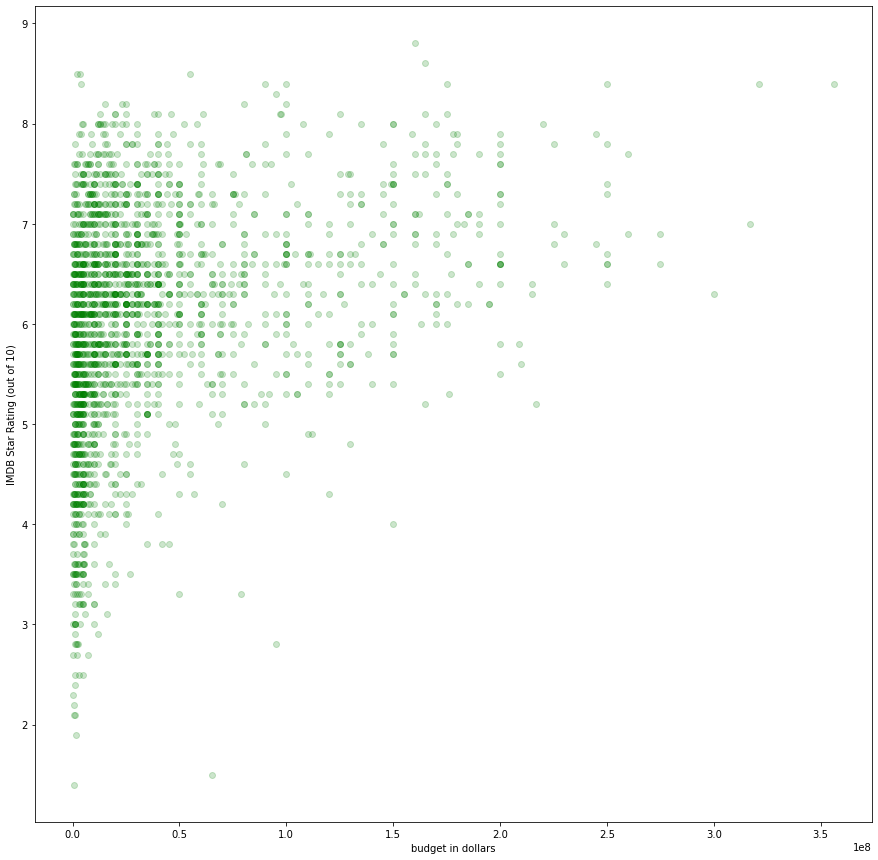

In [600]:
plt.figure(figsize=(15,15))
plt.scatter(rating_budget_series["budget"],rating_budget_series["star_rating"],alpha=0.2,color="green")
plt.xlabel("budget in dollars")
plt.ylabel("IMDB Star Rating (out of 10)");

Notes about graph
* unless budget is over \$50M it does not seem to inform what the rating will be
* After budget gets to \$50M it looks like star rating is a quadratic function of budget

<ipython-input-603-d7ab0ed6e3bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_relyear_series.sort_values(["releaseYear"],inplace=True)


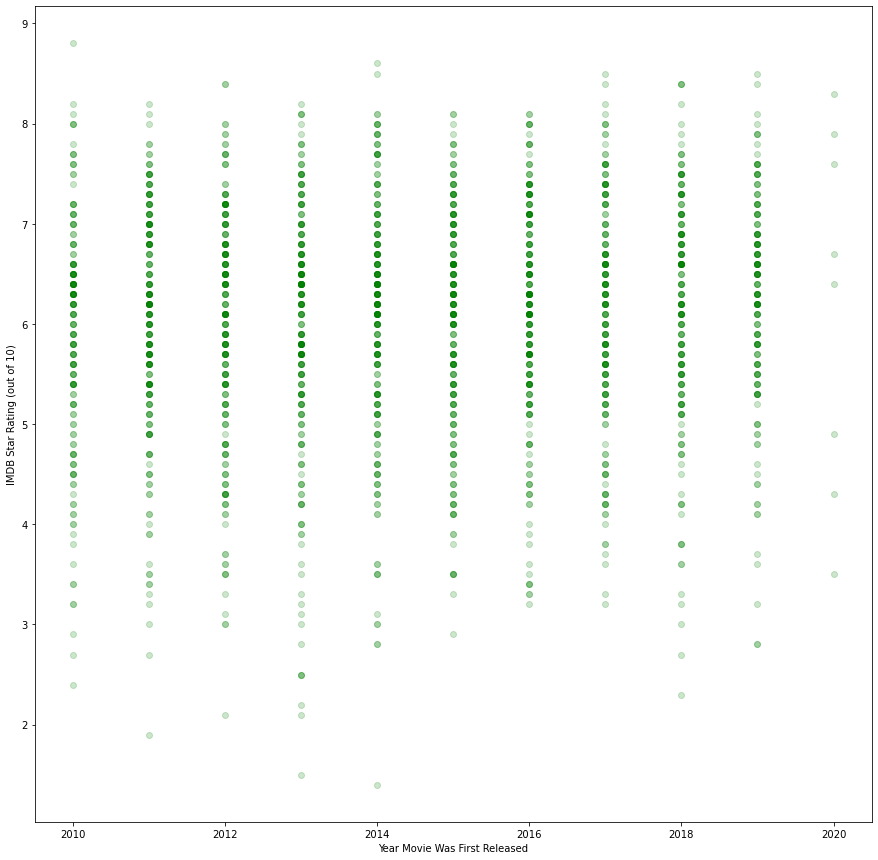

In [603]:
rating_relyear_series = movie_df_processed[["star_rating","releaseYear"]]
rating_relyear_series.sort_values(["releaseYear"],inplace=True)
plt.figure(figsize=(15,15))
plt.scatter(rating_relyear_series["releaseYear"],rating_relyear_series["star_rating"],alpha=0.2,color="green")
plt.xlabel("Year Movie Was First Released")
plt.ylabel("IMDB Star Rating (out of 10)");
#rating_budget_series

Notes on graph
* release year doesn't affect IMDB score. Seems with respect to year, IMDB score is random
* In 2016 is seems IMDB ratings had a high lower bound than other years. Is there a way to include this in the model? Is it significant enough. Correlation says 

In [465]:
#sns.pairplot(movie_df_processed)

In [657]:
star_rating_corr = movie_correlation_df["star_rating"]
star_rating_corr = star_rating_corr[1:]
star_rating_corr = star_rating_corr.abs()
star_rating_corr.sort_values(ascending=False)

budget         0.308271
Horror         0.215753
Biography      0.211000
R              0.118266
PG-13          0.098412
Thriller       0.087795
November       0.086549
Comedy         0.083826
Animation      0.080729
releaseYear    0.072808
Drama          0.067078
December       0.062034
Western        0.058985
Family         0.053104
Adventure      0.047750
Musical        0.047215
Action         0.041017
Crime          0.036226
PG             0.033523
March          0.032424
Mystery        0.031628
May            0.030604
Fantasy        0.023113
NC-17          0.022113
Music          0.022113
April          0.020881
October        0.017824
July           0.017609
September      0.015051
February       0.013317
Sci-Fi         0.009429
Sport          0.006850
January        0.004071
June           0.000861
Romance        0.000717
August         0.000352
Name: star_rating, dtype: float64

# Baseline Model

In [466]:
Y = movie_df_processed["star_rating"]
X = movie_df_processed.drop("star_rating",axis=1)


In [467]:
#hold out 20% for testing
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

In [470]:
baseline_model = LinearRegression()
baseline_model.fit(X_train,Y_train)
train_baseline_score = baseline_model.score(X_train,Y_train)


test_baseline_score = baseline_model.score(X_test,Y_test)
print("test baseline score {} train baseline score {}".format(test_baseline_score, train_baseline_score))

test baseline score 0.19709292628132336 train baseline score 0.23937226616360174


# Model Enhancement


Create a list of the names of the top 5 actors.
Rename `cast1` - `cast3` with the following strings:
* `ACTOR1` to `ACTOR5` if that actor is on the list, otherwise call it `ACTOR0`

Create a list of the names of the top 5 directors.
Rename `director` with one of the folllowing string:
* `DIRECTOR1` to `DIRECTOR5` if the name is on the top-5 director's list. Otherwise name it `DIRECTOR0`


Will use [this source](https://en.wikipedia.org/wiki/Academy_Award_for_Best_Director#Winners_and_nominees) to create list of directors: 

```python
#for movies released 2010-2019
Best_Directors = ["Tim Hooper","Darren Aronofsky",
                  "Joel Coen",
                  "Ethan Coen",
                  
]

```

# Challenge 1
Plot domestic gross over time


I interpret this question to mean to plot the domestic gross for movies in the data frame in the order in which movies were released


create a datetime data type column in the data frame

In [ ]:
movie_df["releasedDateTime"] = pd.to_datetime( movie_df["releaseDate"] )

In [ ]:
movie_df.head()

In [ ]:
movie_df.sort_values(["releasedDateTime"],inplace=True)

In [ ]:
movie_df.head()

In [ ]:
movie_df.tail()

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation="vertical")
plt.plot(movie_df["releasedDateTime"],movie_df["domesticTotalGross"])
plt.title("Plot of Domestic Gross For Movies First Released in 2013")
plt.xlabel("Date")
plt.ylabel("Gross in Dollars")
plt.show()

# Challenge 2
Plot runtime vs. domestic total gross.

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation="vertical")
plt.scatter(movie_df["runtime"],movie_df["domesticTotalGross"],alpha=0.15,color="green")
plt.title("Plot of Domestic Gross vs Run Timr in 2013")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")
plt.show()

# Challenge 3
Group your data by Rating and find the average runtime and domestic total gross at each level of Rating.


In [ ]:
movie_avgruntime_per_rating_df = movie_df.groupby(["rating"])["runtime"].mean().reset_index()

In [ ]:
movie_avgruntime_per_rating_df.head()

In [ ]:
movie_avgruntime_per_rating_df.rename(columns={"runtime":"avg_runtime"},inplace=True)

In [ ]:
movie_avgruntime_per_rating_df

In [ ]:
movie_totdomgross_per_rating_df = movie_df.groupby(["rating"])["domesticTotalGross"].sum().reset_index()

In [ ]:
movie_totdomgross_per_rating_df

In [ ]:
movie_totdomgross_per_rating_df.sort_values(["domesticTotalGross"], inplace=True)

In [ ]:
movie_totdomgross_per_rating_df

# Challenge 4
Make one figure with (N=the number of MPAA ratings there are) subplots, and in each plot the release date vs the domestic total gross.



In [ ]:
 movie_df["rating"].value_counts()

What are the movies with no MPAA Rating?

In [ ]:
pd.set_option('display.max_rows', 20)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
movie_df[ movie_df["rating"]=="" ].head(100)

In [ ]:
plt.figure(figsize=(20,20))
plt.suptitle('domestic tot gross vs release date for movies with the same MPAA rating',fontsize = 16)


plt.subplot(3,2,1) # (number of rows, number of columns, number of plot)
plt.scatter(movie_df[ movie_df["rating"]=="" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="" ]["domesticTotalGross"],alpha=0.2)
plt.title("MPAA Rating Unknown")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,2)
plt.scatter(movie_df[ movie_df["rating"]=="R" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="R" ]["domesticTotalGross"],alpha=0.2,color="green")
plt.title("MPAA Rated R")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,3)
plt.scatter(movie_df[ movie_df["rating"]=="PG-13" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="PG-13" ]["domesticTotalGross"],alpha=0.2,color="purple")
plt.title("MPAA Rated PG-13")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,4)
plt.scatter(movie_df[ movie_df["rating"]=="PG" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="PG" ]["domesticTotalGross"],alpha=0.2,color="red")
plt.title("MPAA Rated PG")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,5)
plt.scatter(movie_df[ movie_df["rating"]=="NC-17" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="NC-17" ]["domesticTotalGross"],color="red",marker="+")
plt.title("MPAA Rated NC-17")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,6)
plt.scatter(movie_df[ movie_df["rating"]=="PG-" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="PG-" ]["domesticTotalGross"],color="black")
plt.title("MPAA Rated PG- (most likely rated PG-13)")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars");


# Challenge 5
What director in your dataset has the highest gross per movie?

Find the gross per director


In [ ]:
movie_totgross_per_director_df = movie_df.groupby(["director"])["domesticTotalGross"].sum().reset_index()

In [ ]:
movie_totgross_per_director_df.sort_values(["domesticTotalGross"],inplace=True,ascending=False)

In [ ]:
movie_totgross_per_director_df.head()

[Francis Lawrence](https://en.wikipedia.org/wiki/Francis_Lawrence) is pretty prolific so the data here seems right.

# Challenge 6
Bin your dataset into months and make a bar graph of the mean domestic total gross by month. Error bars will represent the standard error of the mean.

Title of graph should include: Mean Domestic Total Gross by Month in 2013

Topic for consideration: what is the correct formula for the standard error of the mean? Examine the error bars and see if they are “reasonable.”

Create a new column that holds the name of the month of the release date for  the movie in the same row as the release date

In [ ]:
import seaborn as sns

In [ ]:
movie_df["releasedMonth"] = movie_df["releasedDateTime"].dt.month_name()
movie_df["releasedMonthNumber"] = pd.DatetimeIndex(movie_df["releasedDateTime"]).month

In [ ]:
movie_avggross_per_month = movie_df.groupby(["releasedMonthNumber","releasedMonth"])["domesticTotalGross"].mean().reset_index()

In [ ]:
movie_avggross_per_month.rename(columns={"domesticTotalGross":"domesticMeanGross"},inplace=True)

In [ ]:
movie_avggross_per_month.sort_values(["releasedMonthNumber"],inplace=True)

In [ ]:
movie_avggross_per_month

In [ ]:



months_of_the_year = ["January","February","March","April","May","June","July","August","September","October","November","December"]
list_of_domestic_gross = []

for month_name in months_of_the_year:
    list_of_domestic_gross.append( movie_avggross_per_month[movie_avggross_per_month["releasedMonth"]==month_name]["domesticMeanGross"] )

In [ ]:
#len(list_of_domestic_gross)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(months_of_the_year,list_of_domestic_gross)
plt.xticks(rotation=60)
plt.xlabel("Month of the Year")
plt.ylabel("AVG Domestic Gross")
plt.title("AVG Domestic Gross for all movies released in month on X-axis in 2013")
plt.show();

In [ ]:
plt.figure(figsize=(20,20))
sns.boxplot(y=movie_avggross_per_month["domesticMeanGross"],x=movie_avggross_per_month["releasedMonthNumber"]);
#movie_avggross_per_month.boxplot(figsize=(20,10),by="releasedMonthNumber")

Going to attempt to pull up web site data for movies by name

From inspecting the search result HTML all links to movies are found under these types of HTML elements:

```html
<div class="lister-item-content">
    <h3 class="lister-item-header">
    <!-- Stuff -->
    <a href="LINK_TO_MOVIE">NAME_OF_MOVIE</a>
    <!-- Stuff -->
    </h3>
</div>
      

```

So I should grab all the `<div>` tags with that class and then get the link within them


IMDB Only shows the first 50 movies when you request search results.

So I will need the link to the next 50 movies.

That is located in the web page returned on the search request here:

```html

<div class="desc">
    <a href="LINK_TO_NEXT_PAGE_IN_SEARCH_RESULTS">Next<!--text--></a>
</div>

```